# CESM-LE analysis
### Looks and changes in Fire risk over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='6:00:00')
cluster.scale(ncores)
client = Client(cluster)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44083 instead
  http_address["port"], self.http_server.port


In [8]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:44816 Dashboard: http://10.12.205.30/proxy/44083/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [9]:
def get_file(ee,model,field,component,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
        mm = mlist[ee]
        atm    = '/atm/proc/tseries/day_1/'
        lnd    = '/lnd/proc/tseries/day_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'0101-'+str(firstyear+9)+'1231.'
        if yr>2009:
            yy = '.20100101-20141231.'
        if component == 'lnd': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
        if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
    return ff

In [10]:
'''component = 'land'
ee = 0
model = 'CESM2'
field = 'RAIN'
yr = 2010

topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
mm = mlist[ee]
atm    = '/atm/proc/tseries/day_1/'
lnd    = '/lnd/proc/tseries/day_1/'
firstyear = 10*int(yr/10)
yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
if yr>2009:
    yy = '.20100101-20141231.'

print(mm)
print(lnd)
print(field)
print(yy)
print(mm+lnd+'*.h5.'+field+yy+'*')
if component == 'land': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
print(ff)'''

"component = 'land'\nee = 0\nmodel = 'CESM2'\nfield = 'RAIN'\nyr = 2010\n\ntopdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'\nmlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data\nmm = mlist[ee]\natm    = '/atm/proc/tseries/day_1/'\nlnd    = '/lnd/proc/tseries/day_1/'\nfirstyear = 10*int(yr/10)\nyy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'\nif yr>2009:\n    yy = '.20100101-20141231.'\n\nprint(mm)\nprint(lnd)\nprint(field)\nprint(yy)\nprint(mm+lnd+'*.h5.'+field+yy+'*')\nif component == 'land': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]\nif component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]\nprint(ff)"

In [11]:
def all_files(model,field,firstyear, component,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,component,0) for ee in range(nens)]
    else:
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,component,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [12]:
def get_daily(model,fields,firstyear, component,nens):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, component,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model])
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area']*ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [13]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [14]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in here

In [15]:
%%time

lnd_vars = ['RAIN','SNOW']
model = 'CESM2'
firstyear = 2010
component = 'lnd'
nens = 2  # read in 10 ensemble members for now
ds = get_daily(model,lnd_vars,firstyear, component,nens)
#print(ds)

atm_vars = ['TREFHT','RHREFHT']
component = 'atm'
ds_atm = get_daily(model,atm_vars,firstyear, component,nens)

#ds_atm['TREFHT','RHREFHT']

CPU times: user 727 ms, sys: 102 ms, total: 829 ms
Wall time: 6.28 s


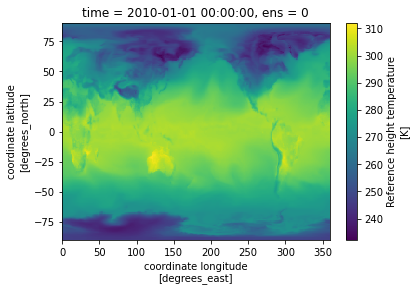

In [16]:
#force coordinate variables to match
ds_atm['lat'] = ds['lat']
ds_atm['lon'] = ds['lon']
ds[atm_vars[0]] = ds_atm[atm_vars[0]]
ds[atm_vars[1]] = ds_atm[atm_vars[1]]
ds[atm_vars[0]].isel(ens=0,time=0).plot();   

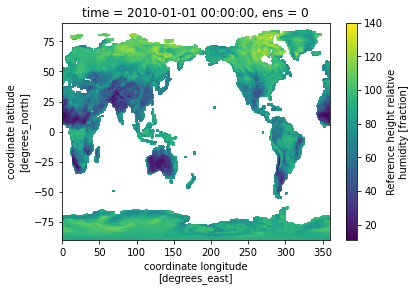

In [17]:
# sum rain + snow for precip.
ds['PPT'] = ds['RAIN']+ds['SNOW']
ds.PPT.attrs['units'] = ds.RAIN.attrs['units']
ds.PPT.attrs['long_name'] = 'Total Precip.'

# mask out oceans for temp and RH
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)
ds['RHREFHT'].isel(time=0,ens=0).plot();

### Calculate Fire Danger Index
- acc_NI is the accumulated Nesterov fire danger index
- d_NI is the daily Nesterov fire danger index, calculated from temp, precip & RH
- from https://github.com/NGEET/fates/blob/master/fire/SFMainMod.F90

  - temp  = TREFHT (in C)
  - ppt   = PPT*sec_per_day (mm)
  - rh    = RHREFHT (fraction)
   
Nesterov Fire danger Index code in FATES: https://github.com/NGEET/fates/blob/8827a6ea77f0e4f5d8408ddd7eeaa776bb3bba8a/fire/SFMainMod.F90#L116-L162


if (ppt > 3.0) !rezero NI if it rains... 
    d_NI = 0.0_r8
    acc_NI = 0.0_r8
else 
    yipsolon = (SF_val_fdi_a* temp_in_C)/(SF_val_fdi_b+ temp_in_C)+log(max(1.0_r8,rh)/100.0_r8) 
    dewpoint = (SF_val_fdi_b*yipsolon)/(SF_val_fdi_a-yipsolon) !Standard met. formula
    d_NI = ( temp_in_C-dewpoint)* temp_in_C !follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
    if (d_NI < 0.0_r8) then !Change in NI cannot be negative. 
          d_NI = 0.0_r8 !check 
    endif
endif

acc_NI = acc_NI + d_NI        !Accumulate Nesterov index over the fire season. 
    
    

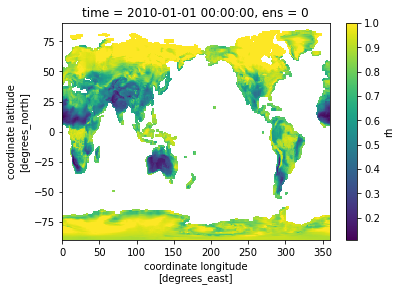

In [18]:
# Fates_fire constants
# Nesterov from EQ 5 Thonicke et al 2010:
fdi_a = 17.62 
fdi_b = 243.12
ds['temp'] = ds['TREFHT'] - 273.15 #convert to degC
ds['rh'] = ds['RHREFHT']/100 # convert to fraction
ds['rh'] = ds['rh'].where(ds.rh<1,1) # set max rh=1
# mask out missing values (again)
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)

ds.rh.isel(time=0, ens=0).plot();

CPU times: user 29.2 s, sys: 2min 10s, total: 2min 39s
Wall time: 19min 23s


'if (d_NI < 0.0_r8) then !Change in NI cannot be negative. \n          d_NI = 0.0_r8 !check \nif (ppt > 3.0) !rezero NI if it rains... \n    d_NI = 0.0_r8\n    acc_NI = 0.0_r8\nelse \n\nacc_NI = acc_NI + d_NI        !Accumulate Nesterov index over the fire season. '

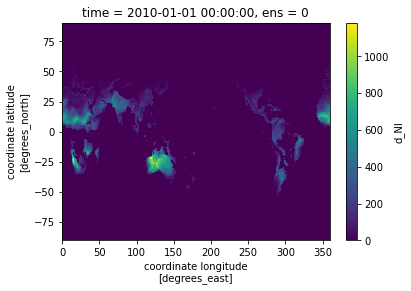

In [19]:
%%time
# This is the calculation that takes forever!
yipsolon = (fdi_a* ds.temp)/(fdi_b+ ds.temp)+np.log(ds.rh).compute(skipna=True) 

#Standard met. formula
dewpoint = (fdi_b*yipsolon)/(fdi_a-yipsolon).compute(skipna=True)   

#follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
ds['d_NI'] = ((ds.temp-dewpoint)* ds.temp).compute(skipna=True) 
# rest d_NI when PPT >3 mm/day
s2d = 3600*24
# don't allow negative values
ds['d_NI'] = ds['d_NI'].where(ds['d_NI']>0,0)  

# Accumulate Nesterov index over the fire season, but reset when daily precip > 3 mm/day. '
# set d_NI to nan when PPT>3 mm /day
ds['d_NI'] = ds['d_NI'].where((ds.PPT*s2d)<3,np.nan)

# plot gridded data
ds['d_NI'].isel(ens=0,time=0).plot()

In [30]:
# select single grid cell
test = ds['d_NI'].sel(lat=25,lon=50, method='nearest').isel(ens=0).values
print(test)

# reset cumulative sum when nan crossed in dataset
# numpy and pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan
n = np.isnan(test)
a = ~n
c = np.cumsum(a)
d = np.diff(np.concatenate(([0.], c[n])))
test[n] = -d
acc_NI = np.cumsum(test)
acc_NI

[140.27544       nan       nan ... 154.78192 216.82779 262.27045]


array([1.4027544e+02, 1.3927544e+02, 1.3927544e+02, ..., 9.9850000e+05,
       9.9871681e+05, 9.9897906e+05], dtype=float32)

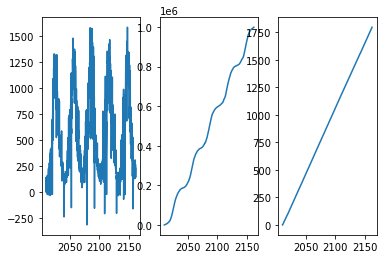

In [42]:
plt.subplot(1,3,1)
plt.plot(ds['time'], test);
plt.subplot(1,3,2)
plt.plot(ds['time'], acc_NI);
plt.subplot(1,3,3)
plt.plot(ds['time'], c);

In [39]:
### something isn't working in 

array([140.27544,  -1.     ,  -0.     , ..., 154.78192, 216.82779,
       262.27045], dtype=float32)

In [43]:
test

array([140.27544,  -1.     ,  -0.     , ..., 154.78192, 216.82779,
       262.27045], dtype=float32)

### Now accumulate the nesterov index over time, resetting when d_NI = 0

In [20]:
%%time
ds['acc_NI_temp'] = ds['d_NI'].cumsum(dim='time').compute(skipna=True)
# use where to set accumulator back to zero
# this will only work the first time... since dNI2 will get reset after frist try...
ds['d_NI2'] =ds['d_NI'].where((ds.PPT*s2d)<3, (-1*ds['acc_NI_temp'])).compute(skipna=True)
ds['acc_NI'] = ds['d_NI2'].cumsum(dim='time').compute(skipna=True)

KeyboardInterrupt: 

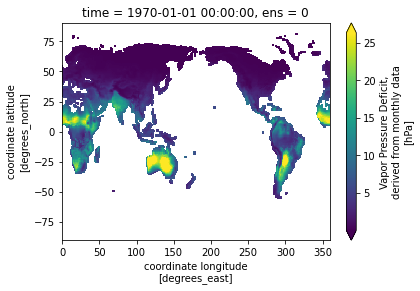

In [17]:
ds['VPD'].isel(time=0,ens=0).plot(robust=True);

### Now calculate iWUE 

In [18]:
%%time
# force the calculation of iWUE, 
# This is really slow...
ds['iWUE'] = (ds.GPP*ds.VPD/ds.ET).compute(skipna=True)

CPU times: user 18.4 s, sys: 1min 20s, total: 1min 38s
Wall time: 5min 35s


In [19]:
# add attributes 
ds.iWUE.attrs['long_name'] = 'Intrinsic water use efficiency'
if WUEmethod == 1:
    ds.iWUE.attrs['units'] = '(gC/kg H2O) hPa'

- set min ET values to avoid crazy high iWUE values?
- annual fluxes, both from grids and globally

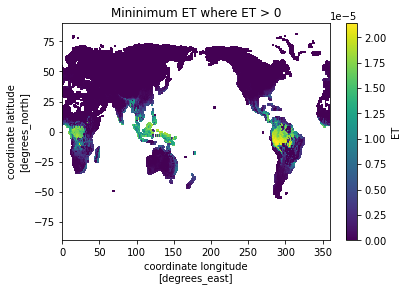

In [20]:
# look at min ET > 0
ds.ET.where(ds.ET>0).min(dim='time').sel(ens=0).plot()
plt.title('Mininimum ET where ET > 0');

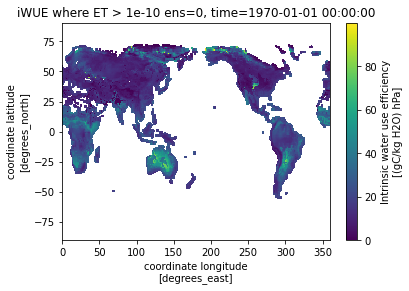

In [21]:
minET = 1e-10
#ds['iWUE2'] = ds.iWUE.where(ds.ET>minET).compute(skipna=True)
ds['iWUE2'] = ds.iWUE.where(ds.iWUE>0).compute(skipna=True)
ds['iWUE2'] = ds.iWUE2.where(ds.iWUE<100).compute(skipna=True)
ds.iWUE2.isel(time=0,ens=0).plot(robust=False);
plt.title('iWUE where ET > '+str(minET)+' ens=0, time='+str(ds.time[0].values));

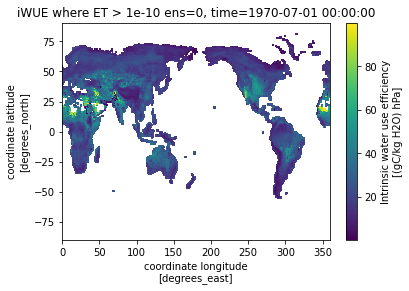

In [22]:
ds.iWUE2.isel(time=6,ens=0).plot(robust=False)
plt.title('iWUE where ET > '+str(minET)+' ens=0, time='+str(ds.time[6].values));

KeyboardInterrupt: 

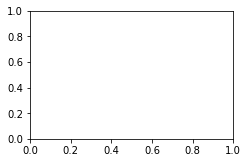

In [24]:
# Look at effects of masking on a single grid
#plt.plot(ds.iWUE.isel(ens=0).sel(lat=50, lon=50, method='nearest'))
plt.figure(figsize=[8,8])
plotVars = ['GPP','VPD','iWUE','ET','iWUE2']
tlat, tlon = 60,150 # 45,260 #50,50 #15,25 #50,300
for i in range(len(plotVars)):
    plt.subplot(3,2,(i+1))
    for j in range(nens):
        plt.plot(ds.time.isel(time=slice(0,60)), ds[plotVars[i]].isel(ens=j,time=slice(0,60)).sel(lat=tlat, lon=tlon, method='nearest'))
    if i<=1: plt.title('lat='+str(tlat)+', lon='+str(tlon));
        
    plt.ylabel(plotVars[i]);

### Calculate annual gridded and global results
#### Should _annual_ fluxes just be for months when GPP or ET are not missing?
- iWUE2 masked where ET values are very low (or values are not 0 or absurd), should this be done for all variables?
- as a result, iWUE2 is not weighted by days / month
- global results weighted so only looking at vegetated grid cells

In [25]:
landarea = 1e6*(ds['area']*ds['landfrac']) #m2
#landarea.plot()
nyears   = len(np.unique(ds['time.year']))
xf1      = 24*60*60   # secs->days
xf2      = 1e-15      # gC->PgC, or Kg->Tt
xf3      = 1e-6*18.015 # umol H20 ->g H20

days_pm    = [31,28,31,30,31,30,31,31,30,31,30,31]

# Creaete long names and units for each variable to sum / average
plotVars = ['GPP','VPD', 'ET', 'iWUE','iWUE2']
varType  = ['sum','WGTmean','sum','WGTmean','mean']
grid_long = ['Annual GPP','Annual VPD','Annual ET','Annual iWUE','masked Annual (0<iWUE<100)']
glob_long = ['Global sum GPP','Global mean VPD','Global sum ET','Global mean iWUE','Global mean (0<iWUE<100)']
grid_unit = ['gC/y', 'hPa','mm/s','gC/kg H2O hPa', 'gC/kg H2O hPa']
glob_unit = ['Pg C/y', 'hPa','Tt H2O/y','gC/kg H2O hPa', 'gC/kg H2O hPa']

# Create datasets to hold output [I think these are dictionaries...]
ann_grid, ann = {}, {}

# loop over annual calculations & global sums / means
for i in range(len(plotVars)):
    if varType[i] == 'sum': # grid weighted by days / month, global sum over land area
        ann_grid[plotVars[i]] = xf1*(month_wts(nyears)*ds[plotVars[i]]).groupby('time.year').sum(skipna=True)
        ann[plotVars[i]] = xf2*(landarea*ann_grid[plotVars[i]]).sum(dim=['lat','lon']) 
       
    if varType[i] == 'WGTmean': # grid weighted by days / month, global weighted by area
        ann_grid[plotVars[i]] = (month_wts(nyears)/365*ds[plotVars[i]]).groupby('time.year').sum(skipna=True) 
        ann[plotVars[i]] = (landwgt*ann_grid[plotVars[i]]).sum(dim=['lat','lon']) 
        
    if varType[i] == 'mean':  # grid NOT weighted by days / month, global weighted by area
        ann_grid[plotVars[i]] = ds[plotVars[i]].groupby('time.year').mean(skipna=True).transpose('year','ens','lat','lon') 
        ann[plotVars[i]] = (landwgt*ann_grid[plotVars[i]]).sum(dim=['lat','lon']).transpose('year','ens') 

    ann_grid[plotVars[i]].attrs['long_name'] = grid_long[i]
    ann_grid[plotVars[i]].attrs['units'] = grid_unit[i]
    ann[plotVars[i]].attrs['long_name'] = glob_long[i]
    ann[plotVars[i]].attrs['units'] = glob_unit[i]

print('Annual calculations finished')

NameError: name 'landwgt' is not defined

### Check results from individual grid cells

In [ ]:
lats = [50,25 ,50 ,60 ] # 1=low porductivity, 2='normal GPP, declining VPD', 
                        #3 = very low productivity years, 5 = SUPER low productivity years [snow covered]
lons = [50,100,300,150]   # evidence for negative WUE in Arctic?
plotVars = ['GPP','VPD', 'ET', 'iWUE','iWUE2']

nrows = len(plotVars)
ncols = len(lats)
plt.figure(figsize=[20,18])
p = 1
for j in range(len(plotVars)):
    for i in range(len(lats)):
        plt.subplot(nrows,ncols,p)
        plt.plot(ann_grid.year, ann_grid[plotVars[j]].sel(lat=lats[i], lon=lons[i], method='nearest'))
        plt.grid()
        if i == 0: plt.ylabel(ann_grid[plotVars[j]].attrs['long_name'])
        if j == 0: plt.title('lat='+str(lats[i])+', lon='+str(lons[i]));
        #if j == 4: plt.xlabel('year')
        p = p+1
plt.subplots_adjust(wspace=0.2);

In [ ]:
# Now plot global results from single ensemble member 
plotVars = ['GPP','VPD', 'ET', 'iWUE','iWUE2']
t = np.unique(ds['time.year'])
plt.figure(figsize=[20,3])

for i in range(len(plotVars)):
    plt.subplot(1,len(plotVars),(1+i))
    plt.title(ann[plotVars[i]].attrs['long_name'])
    plt.xlabel('year')
    plt.ylabel(ann[plotVars[i]].attrs['long_name']+' ('+ann[plotVars[i]].attrs['units']+')')
    for j in range(nens):
        plt.plot(t,ann[plotVars[i]].sel(ens=j))

plt.subplots_adjust(wspace=0.3);

### Look at gridded annual values

In [ ]:
ann_grid['iWUE2'].isel(ens=1,year=1).plot();

------------------
### Calculate linear trends in each grid & ensemble

In [ ]:
# From LENS1 example https://github.com/NCAR/cesm-lens-aws/blob/master/notebooks/kay-et-al-2015.v3.ipynb
def linear_trend(da, dim="year"):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(
        calc_slope,
        da_chunk,
        vectorize=True,
        input_core_dims=[[dim]],
        output_core_dims=[[]],
        output_dtypes=[np.float],
        dask="parallelized",
    )
    return trend


def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))

    # drop missing values (NaNs) from x and y
    finite_indexes = ~np.isnan(y)
    slope = (
        np.nan
        if (np.sum(finite_indexes) < 2)
        else np.polyfit(x[finite_indexes], y[finite_indexes], 1)[0]
    )
    return slope

In [ ]:
# test at a single grid cell
test = linear_trend(ann_grid['iWUE2'].sel(lat=50, lon=300, method='nearest'))
test.plot();

In [ ]:
# Linear trends everywhere
WUE_trends = linear_trend(
    ann_grid['iWUE2'].chunk({"lat": 20, "lon": 20, "year": -1})
).load() #* len(WUE.time)
WUE_trends.attrs['long_name'] = "iWUE trend"
WUE_trends.attrs['units'] = ann_grid['iWUE2'].attrs['units'] + 'per year'

In [ ]:
# Plot mean trends across ensembles
WUE_trends.mean(dim='ens').plot(robust=True, cmap=ccc);
plt.title('mean iWUE2 trends 1970-2014');

In [ ]:
temp = (WUE_trends.mean(dim='ens') - 2*(WUE_trends.std(dim='ens')))
temp = temp.where(temp>0,0).where(ds.area>0)
temp.plot(robust=True);
plt.title('statistically significant iWUE trends (mean - 2SD)');

In [ ]:
# Linear trends everywhere, look at last 25 years, more comparable to Keenan's paper
WUE_trends_short = linear_trend(
    ann_grid['iWUE2'].isel(year=slice(-25,None)).chunk({"lat": 20, "lon": 20, "year": -1})
).load() #* len(WUE.time)

In [ ]:
WUE_trends_short.mean(dim='ens').plot(robust=True, cmap=ccc);
plt.title('mean iWUE2 trends, 1990-2014');

In [ ]:
(WUE_trends_short.mean(dim='ens') - 2*(WUE_trends_short.std(dim='ens'))).plot(robust=True);
plt.title('significant iWUE trends, 1990-2014');

### iWUE = (ca * Ci)/1.6
- from Keenan et al, eq8 
- ca = ambient mole fraction CO2, can get from CO2 forcing file
- Ci = canopy integrated concentration of intercellular CO2
### Ci = ca - iWUE/1.6

In [1]:
client.close()

NameError: name 'client' is not defined

In [ ]:
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`